[Article >>](https://towardsdatascience.com/how-to-find-seasonality-patterns-in-time-series-c3b9f11e89c6/)

In [1]:
import numpy as np

from read import read_data
from graphs import plot_data, create_graph_frequencies
import const

In [2]:
data = read_data()
data

,date,week_day,working,out_of_home,energy,side_projects_time,read_book_time,read_crossword_time,sleep_night_time,sleep_day_time,...,macros_carbs,macros_fat,macros_alcohol,macros_kcal,published_medium,published_linkedin,sleep_total_time,read_total_time,exercise_total_time,exercise_shoulder_raises_volume
0,2024-10-01,1,True,False,3,15.0,0.0,20.0,420.0,0.0,...,190.0,71.0,0.0,1826.0,0,0,420.0,20.0,150.0,0.0
1,2024-10-02,2,True,False,1,60.0,0.0,15.0,360.0,0.0,...,372.0,138.0,0.0,3180.0,0,0,360.0,15.0,20.0,0.0
2,2024-10-03,3,True,False,3,60.0,0.0,15.0,450.0,0.0,...,310.0,118.0,0.0,2783.0,0,0,450.0,15.0,90.0,0.0
3,2024-10-04,4,True,False,1,30.0,0.0,25.0,300.0,180.0,...,281.0,75.0,0.0,2146.0,0,0,480.0,25.0,60.0,0.0
4,2024-10-05,5,False,True,3,120.0,0.0,10.0,360.0,0.0,...,280.0,95.0,14.0,2362.0,0,0,360.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2025-03-27,3,True,False,1,60.0,0.0,0.0,480.0,90.0,...,208.9,131.7,0.0,2593.0,0,0,570.0,0.0,90.0,0.0
178,2025-03-28,4,True,False,3,120.0,5.0,0.0,390.0,60.0,...,176.7,157.5,0.0,2939.0,1,1,450.0,5.0,120.0,360.0
179,2025-03-29,5,False,False,2,420.0,5.0,0.0,480.0,0.0,...,NaN,NaN,NaN,NaN,0,0,480.0,5.0,0.0,NaN
180,2025-03-30,6,False,False,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN


In [18]:
def calculate_fft(values):
    fft_values = np.fft.fft(values)
    frequencies = np.fft.fftfreq(len(values), 1)
    mask = frequencies > 0
    periods = 1 / (frequencies[mask])
    fft_magnitude = np.abs(fft_values) / len(fft_values)
    power_spectrum = np.abs(fft_values)**2 / len(fft_values)
    return periods, fft_values, fft_magnitude, power_spectrum, mask

### Technique (example on week day)

Was I working professionally that day?


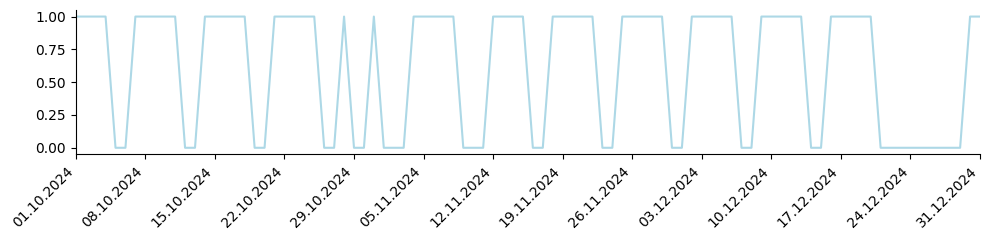

Frequencies amplitudes after Fast Fourier Transform


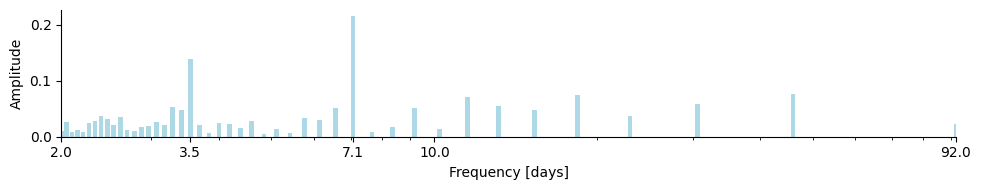

Frequencies power spectrum after Fast Fourier Transform


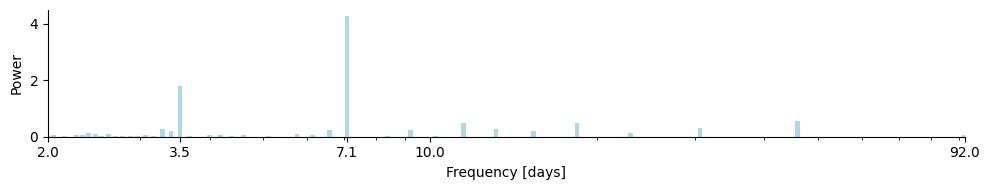

Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 1.5


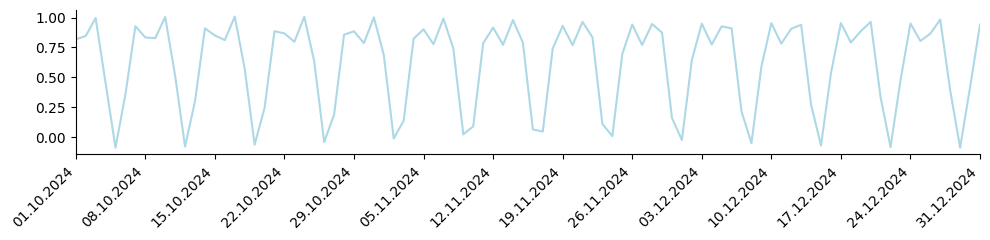

Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 0.1


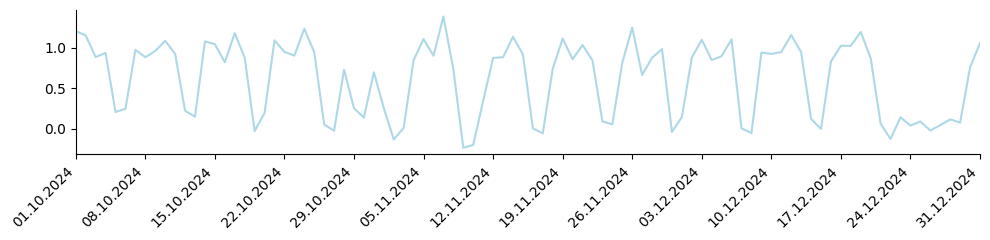

In [4]:
values = data['working'][:92]
index = data['date'][:92]
periods, fft_values, fft_magnitude, power_spectrum, mask = calculate_fft(values)
filtered_fft_low = np.where(power_spectrum >= 0.1, fft_values, 0)
reconstructed_signal_low = np.fft.ifft(filtered_fft_low).real
filtered_fft_high = np.where(power_spectrum >= 1.5, fft_values, 0)
reconstructed_signal_high = np.fft.ifft(filtered_fft_high).real

print('Was I working professionally that day?')
plot_data(values, index)
print('Frequencies amplitudes after Fast Fourier Transform')
create_graph_frequencies(fft_magnitude[mask], periods, 0.1, 0.02, 'Amplitude')
print('Frequencies power spectrum after Fast Fourier Transform')
create_graph_frequencies(power_spectrum[mask], periods, 1.0, 0.02, 'Power')
print('Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 1.5')
plot_data(reconstructed_signal_high, index)
print('Reconstructed signal with Inverese Fast Fourier Transform using power spectrum > 0.1')
plot_data(reconstructed_signal_low, index)


### Data

Frequencies power spectrum after FFT of working


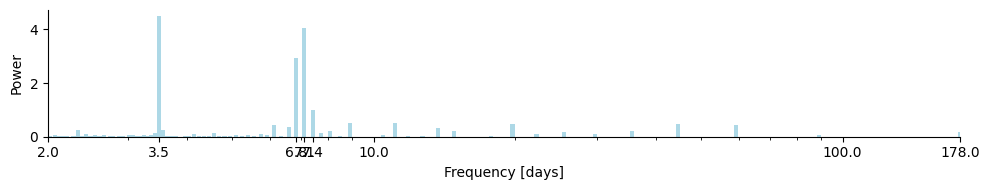

Frequencies power spectrum after FFT of being outside of home


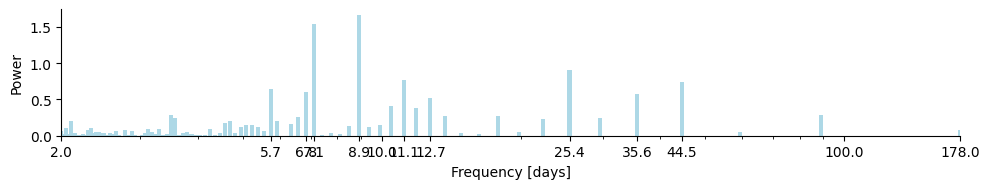

Frequencies power spectrum after FFT of energy levels


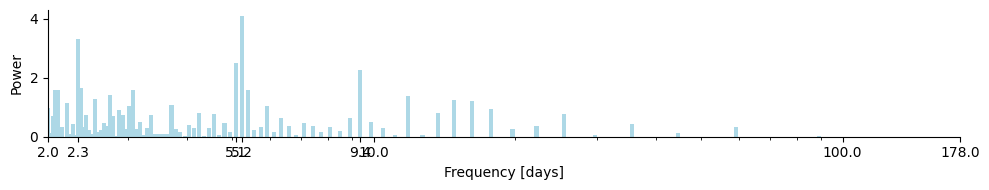

Frequencies power spectrum after FFT of side projects time


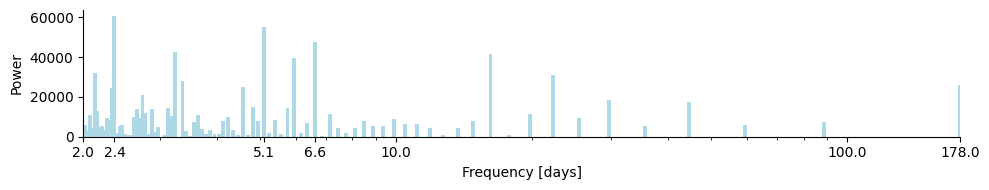

Frequencies power spectrum after FFT of reading time


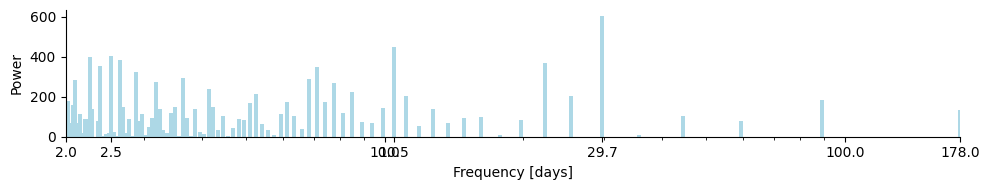

Frequencies power spectrum after FFT of sleeping time


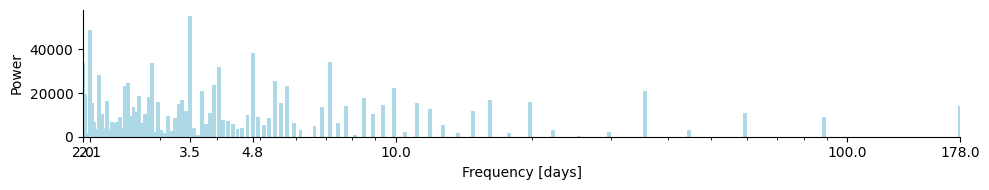

Frequencies power spectrum after FFT of phone usage


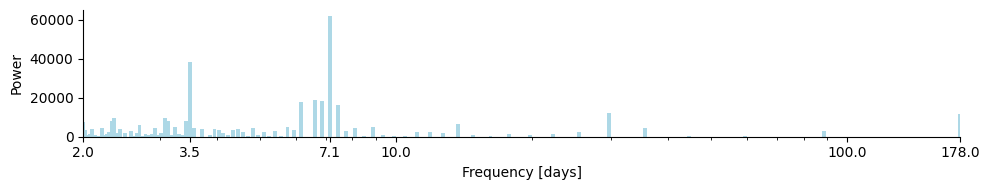

Frequencies power spectrum after FFT of exercise time


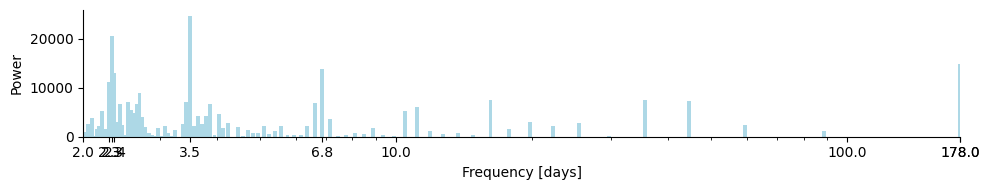

Frequencies power spectrum after FFT of calories consumed


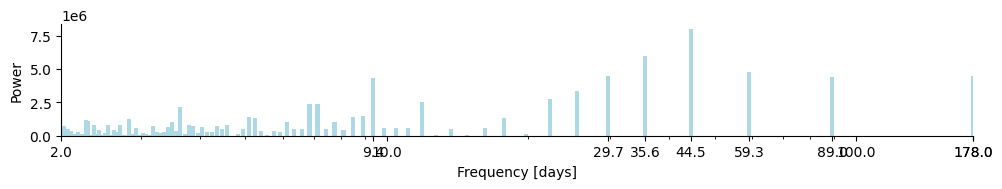

Frequencies power spectrum after FFT of publishing on Medium


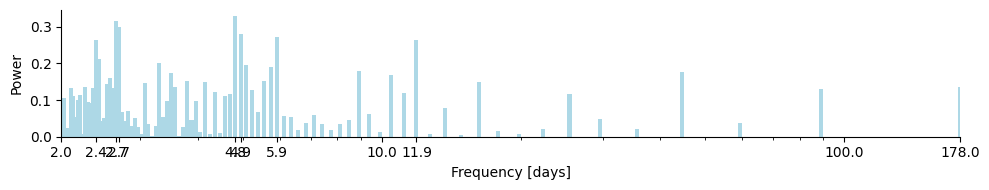

Frequencies power spectrum after FFT of posting on LinkedIn


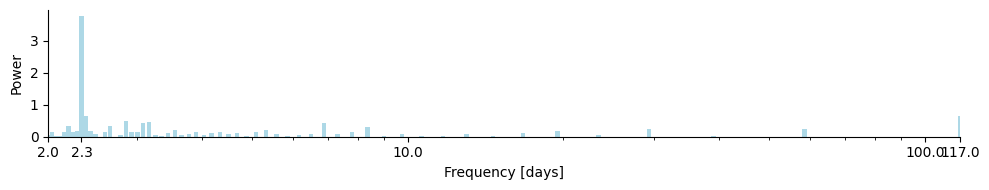

In [42]:
for col, start_index, tick_limit, bar_width, label in [
    (const.COLS_OTHER[2], 0, 1.0, 0.02, 'working'),
    (const.COLS_OTHER[3], 0, 0.5, 0.02, 'being outside of home'),
    (const.COLS_OTHER[4], 0, 2.0, 0.02, 'energy levels'),
    (const.COLS_WORKING[0], 0, 45_000, 0.02, 'side projects time'),
    (const.COLS_READING[2], 0, 400, 0.02, 'reading time'),
    (const.COLS_SLEEPING[2], 0, 35_000, 0.02, 'sleeping time'),
    (const.COLS_LEISURE[0], 0, 35_000, 0.02, 'phone usage'),
    (const.COLS_EXERCISE[6], 0, 10_000, 0.02, 'exercise time'),
    (const.COLS_EATING[4], 0, 4e6, 0.02, 'calories consumed'),
    (const.COLS_PUBLISHING[0], 0, 0.25, 0.02, 'publishing on Medium'),
    (const.COLS_PUBLISHING[1], 61, 1.0, 0.02, 'posting on LinkedIn'),
]:
    print(f'Frequencies power spectrum after FFT of {label}')
    temp_end_index = 178 # TODO remove when all data is available - no NaNs
    periods, _, _, power_spectrum, mask = calculate_fft(data[col][start_index:temp_end_index])
    # plot_data(data[col][start_index:temp_end_index], data['date'][start_index:temp_end_index])
    create_graph_frequencies(power_spectrum[mask], periods, tick_limit, bar_width, 'Power')